In [35]:
import json
import pandas as pd

with open("../chat_history_tfidf.json") as f:
    data = json.load(f)
    df = pd.json_normalize(data)
    df["test_name"] = "tfidf"

df['gpu_energy.joules'] = df['gpu_energy'] * 3600000
df['gpu_energy.request'] = df['gpu_energy.joules'] / 100
df = df.loc[~df.debug_mode]

In [36]:
df.set_index('sensitivity', inplace=True)

config.info.max_tokens
15000    Axes(0.125,0.11;0.775x0.77)
30000    Axes(0.125,0.11;0.775x0.77)
Name: score, dtype: object

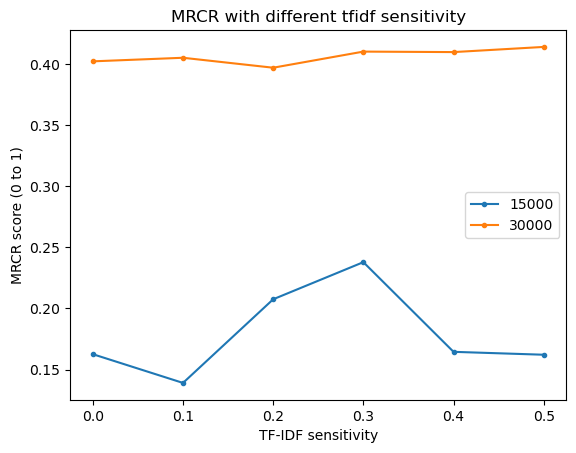

In [37]:
df.groupby('config.info.max_tokens')['score'].plot(
    legend=True,
    xlabel='TF-IDF sensitivity',
    ylabel='MRCR score (0 to 1)',
    rot=0,
    title='MRCR with different tfidf sensitivity',
    style='.-',
)

config.info.max_tokens
15000    Axes(0.125,0.11;0.775x0.77)
30000    Axes(0.125,0.11;0.775x0.77)
Name: gpu_energy.request, dtype: object

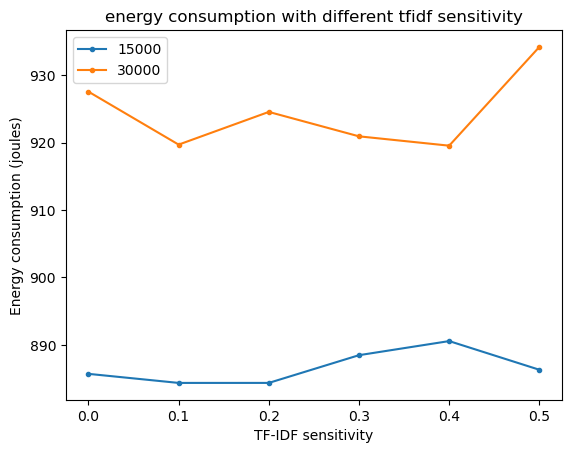

In [38]:
df.groupby('config.info.max_tokens')['gpu_energy.request'].plot(
    legend=True,
    xlabel='TF-IDF sensitivity',
    ylabel='Energy consumption (joules)',
    rot=0,
    title='energy consumption with different tfidf sensitivity',
    style='.-',
)